In [0]:
# for vectors manipulation
import numpy as np

# for plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# visualize plots in the jupyter notebook
# check more https://goo.gl/U3Ai8R
%matplotlib inline

# for generating random values
import random

# for representing things like card value or colors
from enum import Enum  

# for copying python objects
import copy

from tqdm import tqdm_notebook, tqdm

from pylab import rcParams

In [0]:
#method adapted from Easy21 assignment of https://github.com/analog-rl/Easy21
def plot_value_function(agent_type, value_function, method, title='Value Function', usables=[0,0,0], generate_gif=False, train_steps=None, save=None, transpose=True):
    """
    Plots a value function as a surface plot, like in: https://goo.gl/aF2doj

    You can choose between just plotting the graph for the value function
    which is the default behaviour (generate_gif=False) or to train the agent
    a couple of times and save the frames in a gif as you train.

    Args:
        agent: An agent.
        title (string): Plot title.
        generate_gif (boolean): If want to save plots as a gif.
        train_steps: If is not None and generate_gif = True, then will use this
                     value as the number of steps to train the model at each frame.
    """
    # you can change this values to change the size of the graph
    title += ' (' + str(train_steps) + ' Episodes, Usables ' + str(usables) + ', ' + method + ')'
    title = agent_type + ' ' + title
    fig = plt.figure(title, figsize=(10, 5))
    
    # explanation about this line: https://goo.gl/LH5E7i
    ax = fig.add_subplot(111, projection='3d')
    
    if transpose:
        V = np.transpose(value_function[:,:,usables[0],usables[1],usables[2]])
    else:
        V = value_function[:,:,usables[0],usables[1],usables[2]]
    
    if generate_gif:
        print('gif will be saved as %s' % title)
    
    def plot_frame(ax):
        # min value allowed accordingly with the documentation is 1
        # we're getting the max value from V dimensions
        min_x = 1
        max_x = V.shape[0]
        min_y = 1
        max_y = V.shape[1]

        # creates a sequence from min to max
        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)

        # creates a grid representation of x_range and y_range
        X, Y = np.meshgrid(x_range, y_range)

        # get value function for X and Y values
        def get_stat_val(x, y):
            return V[x, y]
        Z = get_stat_val(X, Y)

        # creates a surface to be ploted
        # check documentation for details: https://goo.gl/etEhPP
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Value')
        return ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                               linewidth=0, antialiased=False)
    
    def animate(frame):
        # clear the plot and create a new surface
        ax.clear()
        surf = plot_frame(ax)
        # if we're going to generate a gif we need to train a couple of times
        if generate_gif:
            i = agent.iterations
            # cool math to increase number of steps as we go
            if train_steps is None:
                step_size = int(min(max(1, agent.iterations), 2 ** 16))
            else:
                step_size = train_steps

            agent.train(step_size)
            plt.title('%s MC score: %s frame: %s' % (title, float(agent.wins)/agent.iterations*100, frame))
        else:
            plt.title(title)

        fig.canvas.draw()
        return surf

    ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

    # requires gif writer
    if generate_gif:
        ani.save(title + '.gif', writer='imagemagick', fps=3)
    else:
        if save is None:
            plt.show()
            plt.close()
        else:
            plt.savefig(save)
            plt.close('all')

In [0]:
class Color(Enum):
    BLACK = 0
    RED = 1

class Card(object):
    def __init__(self, color=None, value=None):
        if value is not None:
            self.value = value
        else:
            self.value = random.randint(1, 10)
        if color == Color.BLACK or color == Color.RED:
            self.color = color
        else:
            random_num = random.random()
            if(random_num <= (1.0/3)):
                self.color = Color.RED
            else:
                self.color = Color.BLACK

class Deck(object):
    def sample_card(self, color=None, value=None):
        return Card(color, value)
    


In [0]:
# State characterised by (agent_sum, dealer_sum, Usable1, Usable2, Usable3)
# Usable1 = 0 -> there is no usable 1 in the current hand
class State(object):
    def __init__(self, agent_sum=0, show_card=0, agent_usables=[0,0,0], dealer_sum=0, dealer_usables=[0,0,0], is_terminal=False):
        self.show_card = show_card
        self.agent_sum = agent_sum
        self.dealer_sum = dealer_sum
        self.agent_usables = agent_usables
        self.dealer_usables = dealer_usables
        self.is_terminal = is_terminal
        
    def get_tuple(self):
        usables = self.agent_usables
        return (self.agent_sum, self.show_card-4 , usables[0], usables[1], usables[2])


class Action(Enum):
    HIT = 0
    STICK = 1
        

In [0]:

class Player(object):
    def policy(self, state):
        raise NotImplemented()

class Dealer(object):
    def policy(self, state):
        if(state.dealer_sum >= 25):
            return Action.STICK
        else:
            return Action.HIT

In [0]:
class Environment(object):
    def __init__(self):
        self.deck = Deck()
        self.dealer = Dealer()
        self.agent_max_value = 32  # max value an agent can get during the game
        self.dealer_max_value = 10  # max value the dealer can get when taking the first card
        self.usable_1_values = 3 # can take states 0(not-present), 1(usable) or 2(non-usable) for card-value 1
        self.usable_2_values = 3 # can take states 0(not-present), 1(usable) or 2(non-usable) for card-value 2
        self.usable_3_values = 3 # can take states 0(not-present), 1(usable) or 2(non-usable) for card-value 3
        self.actions_count = 2  # number of possible actions in each state
        
    def check_bust(self, current_sum):
        return (current_sum < 0) or (current_sum > 31)
    
    # get reward when both of them have sticked without going bust
    def get_reward_bust(self, state):
        if(state.agent_sum > state.dealer_sum):
            return 1
        elif(state.agent_sum == state.dealer_sum):
            return 0
        return -1
    
    def sample_card_value(self, color=None, value=None):
        card = self.deck.sample_card(color, value)
        if(card.color == Color.BLACK):
            return card.value
        else:
            return -card.value
    
    def update_dealer_usables(self, state, card_value):
        if(card_value == 1 or card_value == 2 or card_value == 3):
            idx = card_value - 1
            old_state = state.dealer_usables[idx]
            if(old_state == 0):
                # previously not present
                # value can either be new_value or (new_value + 10)
                if self.check_bust(state.dealer_sum + card_value + 10):
                    # going bust when using (new_value + 10)
                    # make it non-usable
                    new_state = 2
                else:
                    # can use it as a usable card, add 10 and make it usable
                    card_value += 10
                    new_state = 1
            elif(old_state == 1):
                # previously used as a usable
                new_state = 2
            else:
                new_state = 2
            state.dealer_usables[idx] = new_state
        return state, card_value
    
    def update_agent_usables(self, state, card_value):
        if(card_value == 1 or card_value == 2 or card_value == 3):
            idx = card_value - 1
            old_state = state.agent_usables[idx]
            if(old_state == 0):
                # previously not present
                # value can either be new_value or (new_value + 10)
                if self.check_bust(state.agent_sum + card_value + 10):
                    # going bust when using (new_value + 10)
                    # make it non-usable
                    new_state = 2
                else:
                    # can use it as a usable card, add 10 and make it usable
                    card_value += 10
                    new_state = 1
            elif(old_state == 1):
                # previously used as a usable
                new_state = 2
            else:
                new_state = 2
            state.agent_usables[idx] = new_state
        return state, card_value
        
    # play dealer's turn when the agent has sticked    
    def play_dealer(self, state):
        while(True):
            action = self.dealer.policy(state)
            if(action == Action.HIT):
                new_card_value = self.sample_card_value()
                state, new_card_value = self.update_dealer_usables(copy.deepcopy(state), new_card_value)
                state.dealer_sum += new_card_value
            state.is_terminal = self.check_bust(state.dealer_sum)
            if(state.is_terminal or (action == Action.STICK)):
                break
        return state
        
    # Both the dealer and agent take one card each, dealer's card is visible to the agent
    def initial_state(self):
        agent_card_value = self.sample_card_value()
        dealer_card_value = self.sample_card_value()
        state = State(agent_usables=[0,0,0], dealer_usables=[0,0,0])
        state, agent_card_value = self.update_agent_usables(copy.deepcopy(state), agent_card_value)
        state, dealer_card_value = self.update_dealer_usables(copy.deepcopy(state), dealer_card_value)
        state.agent_sum += agent_card_value
        state.dealer_sum += dealer_card_value
        state.show_card = dealer_card_value
        agent_busted = self.check_bust(state.agent_sum)
        dealer_busted = self.check_bust(state.show_card)
        if (agent_busted or dealer_busted):
            state.is_terminal = True
        else:
            state.is_terminal = False
        return state
    
    # Given (state, action) return (next_state, reward)
    def step(self, state, action):
        agent_sum = state.agent_sum
        show_card = state.show_card
        agent_usables = state.agent_usables
        reward = 0
        next_state = copy.deepcopy(state)
        if(state.is_terminal):
            print('Cannot take action on a terminal state')
        if action == Action.STICK:
            next_state = self.play_dealer(copy.deepcopy(state))
            if next_state.is_terminal:
                reward = 1
            else:
                next_state.is_terminal = True
                reward = self.get_reward_bust(next_state)
        else:
            agent_card_value = self.sample_card_value()
            next_state, agent_card_value = self.update_agent_usables(copy.deepcopy(state), agent_card_value)
            next_state.agent_sum += agent_card_value
            next_state.is_terminal = self.check_bust(next_state.agent_sum)
            if next_state.is_terminal:
                reward = -1
        return next_state, reward

In [0]:

class Agent(Player):
    def __init__(self, environment, discount_factor=1.0):
        Player.__init__(self)
        self.env = environment
        self.discount_factor = discount_factor
        self.value_function = np.zeros([self.env.agent_max_value, \
                                        self.env.dealer_max_value, \
                                        self.env.usable_1_values, \
                                        self.env.usable_2_values, \
                                        self.env.usable_3_values])
        self.action_value_function = np.zeros([self.env.agent_max_value, \
                                              self.env.dealer_max_value, \
                                              self.env.usable_1_values, \
                                              self.env.usable_2_values, \
                                              self.env.usable_3_values, \
                                              self.env.actions_count])
        self.matches_won = 0.0
        self.matches_draw = 0.0
        self.matches_lose = 0.0
        self.num_games_played = 0.0
    
    def get_value_function(self):
        for i in range(self.env.agent_max_value):
            for j in range(self.env.dealer_max_value):
                for k in range(self.env.usable_1_values):
                    for l in range(self.env.usable_2_values):
                        for m in range(self.env.usable_3_values):
                            s = State(i,j+4,[k,l,m])
                            action = self.take_greedy_action(s)
                            satup = s.get_tuple() + (action.value, )
                            self.value_function[s.get_tuple()] = self.action_value_function[satup]
        return self.value_function
    
    def get_action_value_function(self):
        return self.action_value_function
        
    def take_random_action(self):
        num = random.random()
        if num <= 0.5:
            return Action.HIT
        return Action.STICK
    
    def take_greedy_action(self, state):
        stup = state.get_tuple()
        Q = self.get_action_value_function()
        return Action(np.argmax(Q[stup]))

In [0]:
class MCAgentEvaluation(Agent):
    def __init__(self, environment, discount_factor=1):
        Agent.__init__(self, environment, discount_factor)
        self.visit_count_V = np.zeros([self.env.agent_max_value, \
                            self.env.dealer_max_value, \
                            self.env.usable_1_values, \
                            self.env.usable_2_values, 
                            self.env.usable_3_values])
        self.visit_count_Q = np.zeros([self.env.agent_max_value, \
                           self.env.dealer_max_value, \
                           self.env.usable_1_values, \
                           self.env.usable_2_values, \
                           self.env.usable_3_values, \
                           self.env.actions_count])
        
    
    def predict_V(self, episode, method='all-visit'):
        T = len(episode)
        gamma = self.discount_factor
        last_reward = episode[T - 1][2]
        visit_set = set()
        for ep_num, (s, a, r) in enumerate(episode):
            stup = s.get_tuple()
            G = (gamma ** (T - 1 - ep_num)) * last_reward * 1.0
            k = self.visit_count_V[stup]
            mean_old = self.value_function[stup]
            if method == 'first-visit':
                if not stup in visit_set:
                    self.value_function[stup] = (1.0 * ((k * mean_old) + G))/(k + 1) 
                    self.visit_count_V[stup] = k + 1
                    visit_set.add(stup)
            else:
                self.value_function[stup] = (1.0 * ((k * mean_old) + G))/(k + 1) 
                self.visit_count_V[stup] = k + 1
                
    def predict_Q(self, episode, method='all-visit'):
        T = len(episode)
        gamma = self.discount_factor
        last_reward = episode[T - 1][2]
        visit_set = set()
        for ep_num, (s, a, r) in enumerate(episode):
            stup = s.get_tuple()
            satup = stup + (a.value,)
            G = (gamma ** (T - 1 - ep_num)) * last_reward * 1.0
            k = self.visit_count_Q[satup]
            mean_old = self.action_value_function[satup]
            if method == 'first-visit':
                if not satup in visit_set:
                    self.action_value_function[satup] = (1.0 * ((k * mean_old) + G))/(k + 1) 
                    self.visit_count_Q[satup] = k + 1
                    visit_set.add(satup)
            else:
                self.action_value_function[satup] = (1.0 * ((k * mean_old) + G))/(k + 1) 
                self.visit_count_Q[satup] = k + 1
        
    
    def policy(self, state):
        if(state.agent_sum >= 25):
            return Action.STICK
        else:
            return Action.HIT
        
    def generate_episode(self, es=False):
        episode = []
        state = self.env.initial_state()
#         if(state.is_terminal):
#             print('terminal state')
#             state._print_state_()
        while not state.is_terminal:
            
            # choose action as per agent's policy
            if es:
                action = self.take_random_action()
                es = False
            else:
                action = self.policy(state)

            # execute action in the env and gather rewards
            next_state, reward = self.env.step(copy.deepcopy(state), action)

            # store the episode
            episode.append((copy.deepcopy(state), action, reward))

            # update the state
            state = next_state
            
        return episode
    
    def train_V(self, num_episodes, method='all-visit'):
        epi_num = 0
        pbar = tqdm(total=num_episodes)
        while epi_num < num_episodes:
            episode = self.generate_episode(es=False)
            if(len(episode) == 0):
                continue
            self.num_games_played += 1.0
            self.predict_V(episode, method)
#             if epi_num % 100 == 0 and epi_num != 0:
#                 print("Episode: %d" % epi_num)
            pbar.update(1)
            epi_num += 1
        pbar.close()
        return self.value_function
    
    def train_Q(self, num_episodes, method='all-visit'):
        epi_num = 0
        pbar = tqdm(total=num_episodes)
        while epi_num < num_episodes:
            episode = self.generate_episode(es=True)
            if(len(episode) == 0):
                continue
            self.num_games_played += 1.0
            self.predict_Q(episode, method)
#             if epi_num % 100 == 0 and epi_num != 0:
#                 print("Episode: %d" % epi_num)
            pbar.update(1)
            epi_num += 1
        pbar.close()
        return self.action_value_function


In [0]:
def train_and_save_MC(num_episodes, method):
    environment = Environment()
    mc_agent = MCAgentEvaluation(environment)
    V = mc_agent.train_V(num_episodes, method)
    for i in range(0,3):
        for j in range(0,3):
            for k in range(0,3):
                
                plot_value_function('MC', V, method=method, train_steps=num_episodes, usables=[i,j,k])

100%|██████████| 10000/10000 [00:06<00:00, 1556.28it/s]


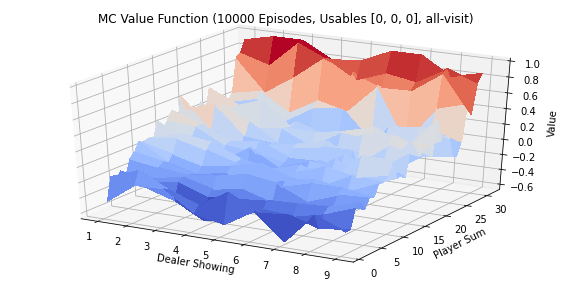

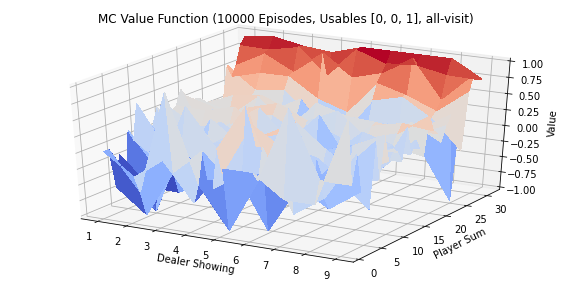

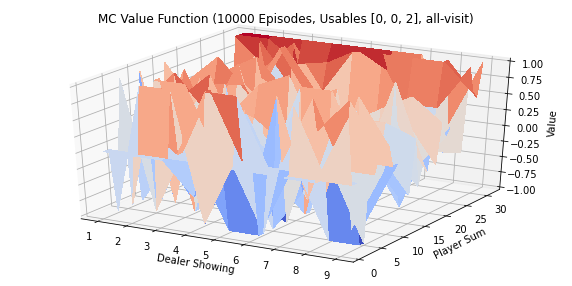

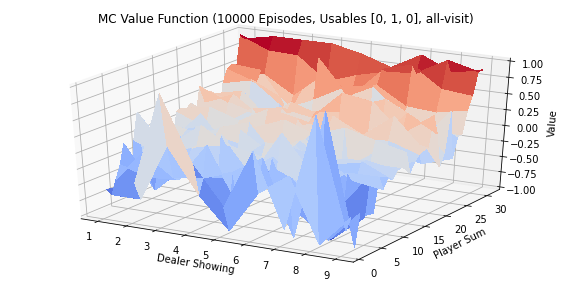

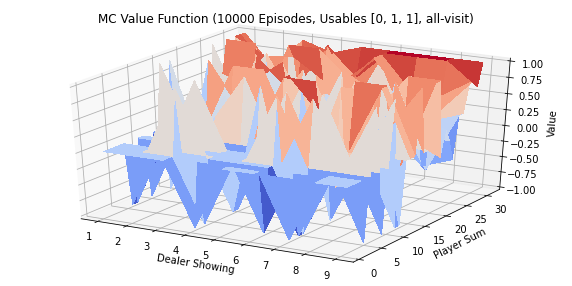

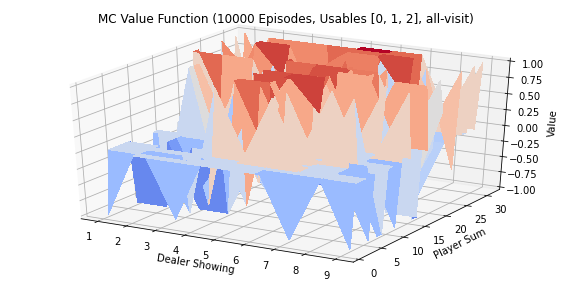

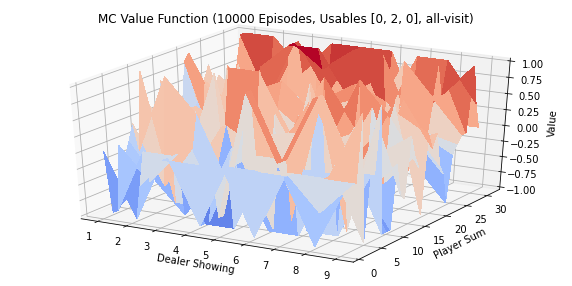

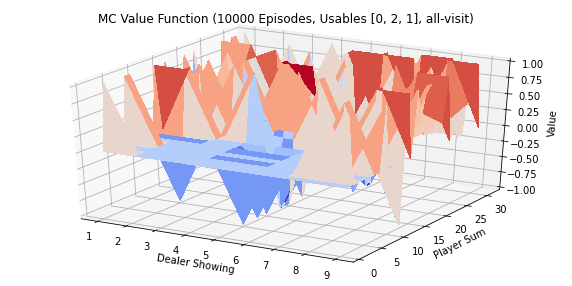

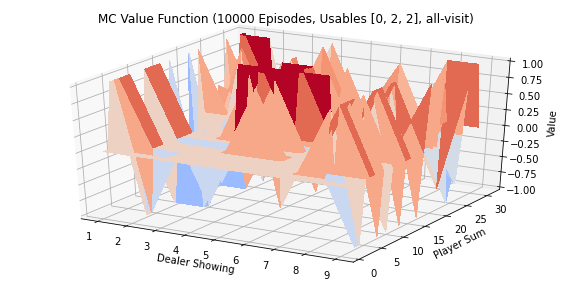

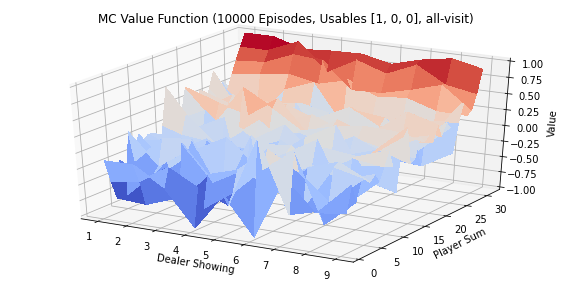

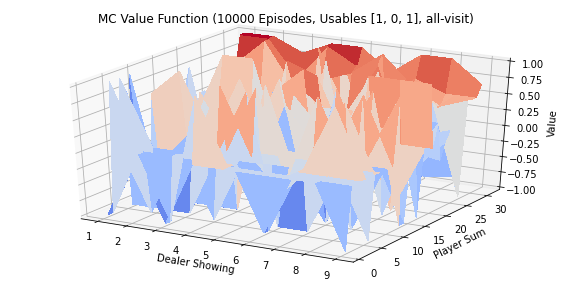

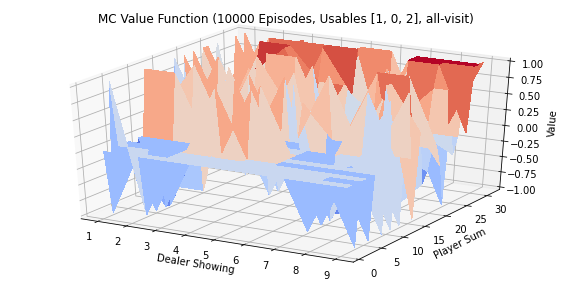

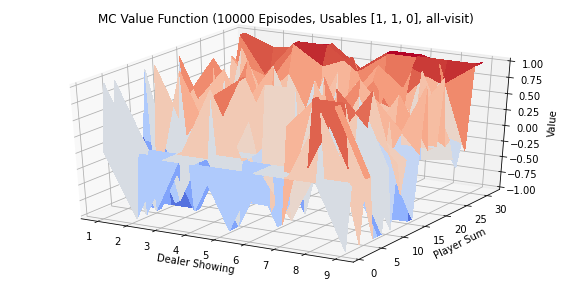

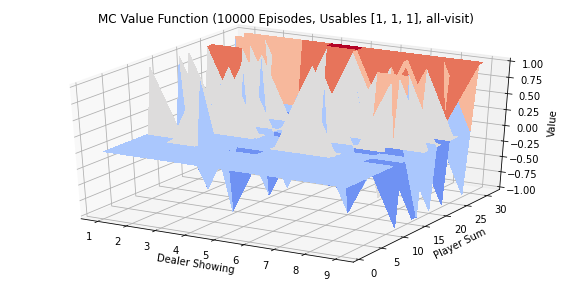

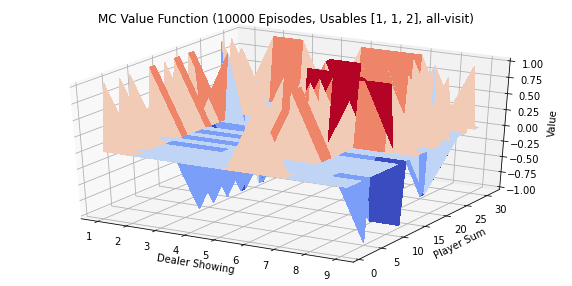

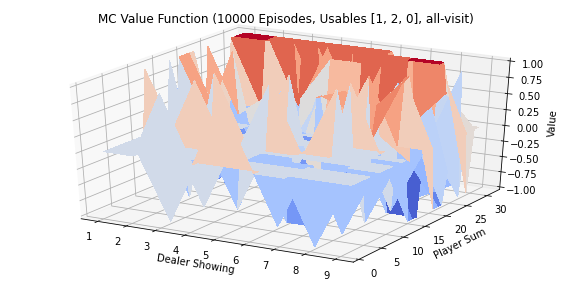

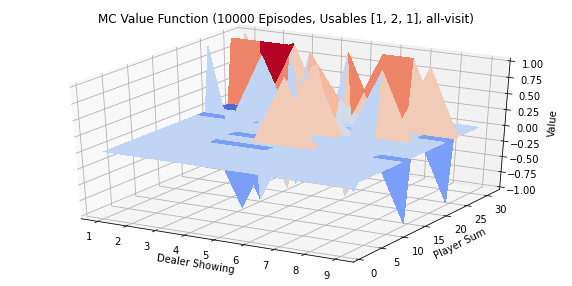

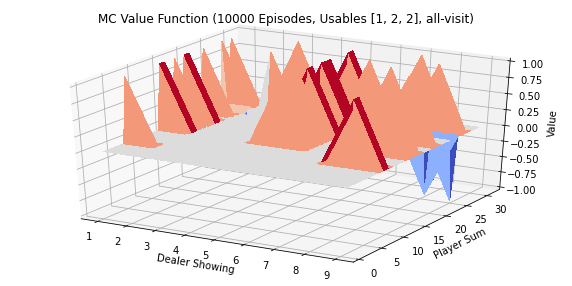

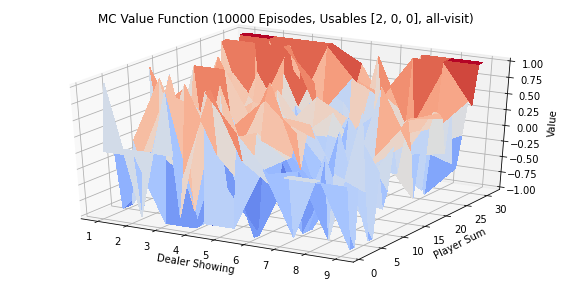

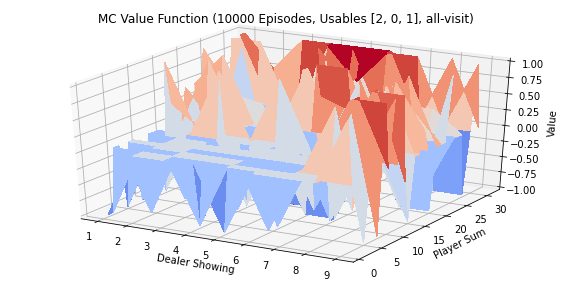

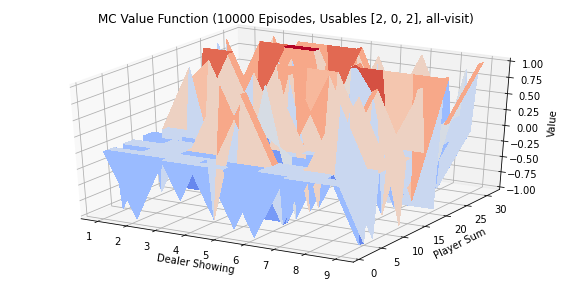

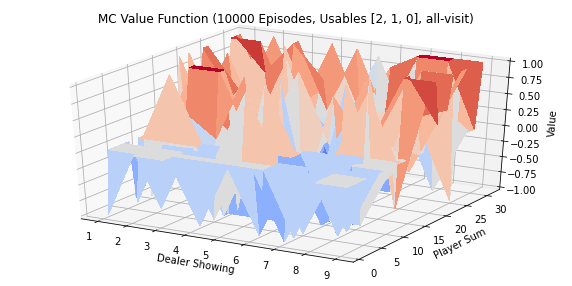

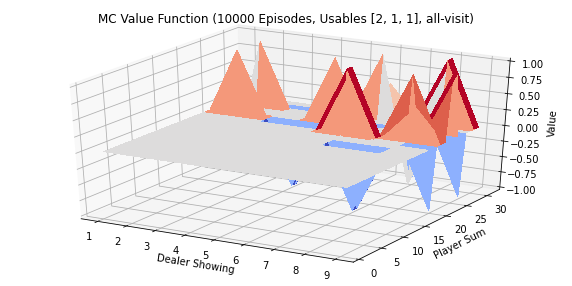

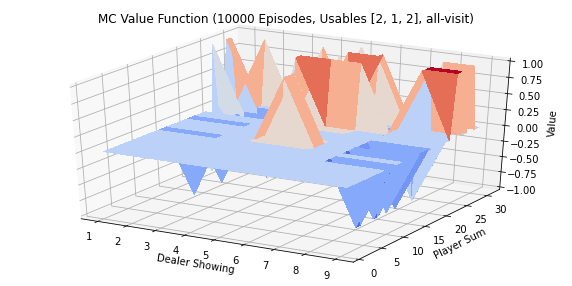

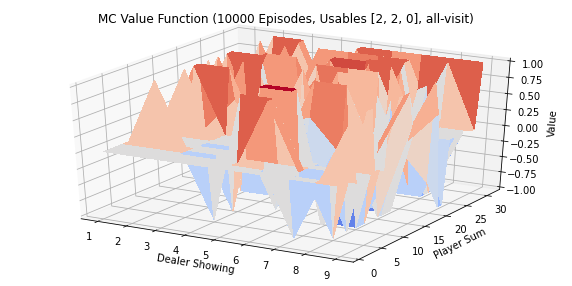

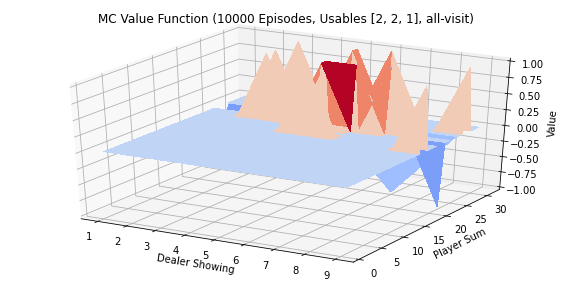

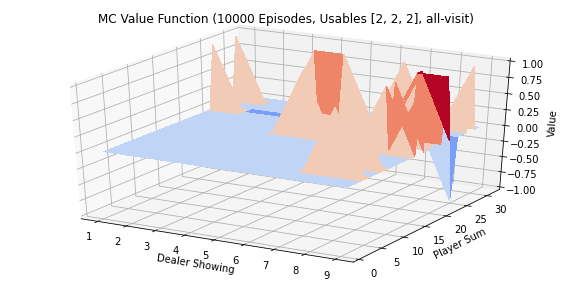

In [0]:
train_and_save_MC(10000,'all-visit') 

In [0]:
class kTDEvaluation(Agent):
    def __init__(self, environment, discount_factor=1, alpha=0.1, k=1):
        Agent.__init__(self, environment, discount_factor)
        self.alpha =  alpha
        self.k = k
    
    def policy(self, state):
        if(state.agent_sum >= 25):
            return Action.STICK
        else:
            return Action.HIT
        
    def train_V(self, num_episodes=100):
        pbar = tqdm(total=num_episodes)
        for i in range(num_episodes):
            
            # get a non-terminal state S0
            state = self.env.initial_state()
            while(state.is_terminal):
                state = self.env.initial_state()

            # store_states
            states_seen = {}
            states_seen[0] = state.get_tuple()

            # initialise T <- infinity
            T = float('inf')
            t = 0
            last_reward = 0
            k = self.k
            tau = 1 - k
            gamma = self.discount_factor
            alpha = self.alpha
    
            while(tau != (T - 1)):
                if t < T:
                    if not state.is_terminal:
                        action = self.policy(state)
                        next_state, reward = self.env.step(copy.deepcopy(state), action)
                        states_seen[t + 1] = next_state.get_tuple()
                        state = next_state
                    if(next_state.is_terminal):
                        T = t + 1
                        last_reward = reward
                tau = t - k + 1
                if tau >= 0:
                    G = 0
                    var G = Σ(1..min(n, T - τ)) { pow(γ, it - 1) * R[it] }
                    if T != float('inf'):
                        G = ((gamma ** (T - tau - 1)) * last_reward)
                    if (tau + k < T):
                        stup = states_seen[tau + k]
                        G += ((gamma ** k) * self.value_function[stup])
                    stup_to_update = states_seen[tau]
                    self.value_function[stup_to_update] += (alpha * (G - self.value_function[stup_to_update]))
                t += 1
            pbar.update(1)
        pbar.close()
        return self.value_function
    
    def train_Q(self, num_episodes=100):
        pbar = tqdm(total=num_episodes)
        for i in range(num_episodes):
            
            # get a non-terminal state S0
            state = self.env.initial_state()
            while(state.is_terminal):
                state = self.env.initial_state()

            # store_states
            states_seen = {}
            action = self.take_random_action()
            states_seen[0] = state.get_tuple() + (action.value,)

            # initialise T <- infinity
            T = float('inf')
            t = 0
            last_reward = 0
            k = self.k
            tau = 1 - k
            gamma = self.discount_factor
            alpha = self.alpha
    
            while(tau != (T - 1)):
                if t < T:
                    next_state, reward = self.env.step(copy.deepcopy(state), action)
                    if not next_state.is_terminal:
                        next_action = self.policy(next_state)
                        satup = next_state.get_tuple() + (next_action.value,)
                        states_seen[t + 1] = satup
                        state = next_state
                        action = next_action
                    if(next_state.is_terminal):
                        T = t + 1
                        last_reward = reward
                tau = t - k + 1
                if tau >= 0:
                    G = 0
                    if T != float('inf'):
                        G = ((gamma ** (T - tau - 1)) * last_reward)
                    if (tau + k < T):
                        stup = states_seen[tau + k]
                        G += ((gamma ** k) * self.action_value_function[stup])
                    stup_to_update = states_seen[tau]
                    self.action_value_function[stup_to_update] += (alpha * (G - self.action_value_function[stup_to_update]))
                t += 1
            pbar.update(1)
        pbar.close()
        return self.action_value_function

  0%|          | 0/10000 [00:00<?, ?it/s]

IndexError: ignored